## Paso 1:


206
(2000, 206) (206,) (206, 206)


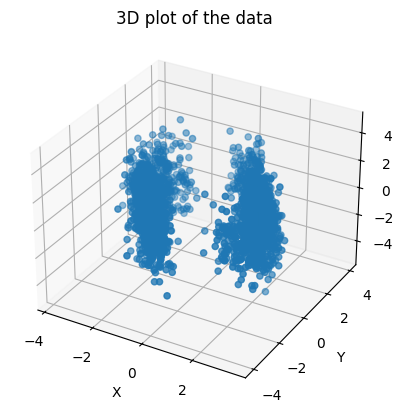

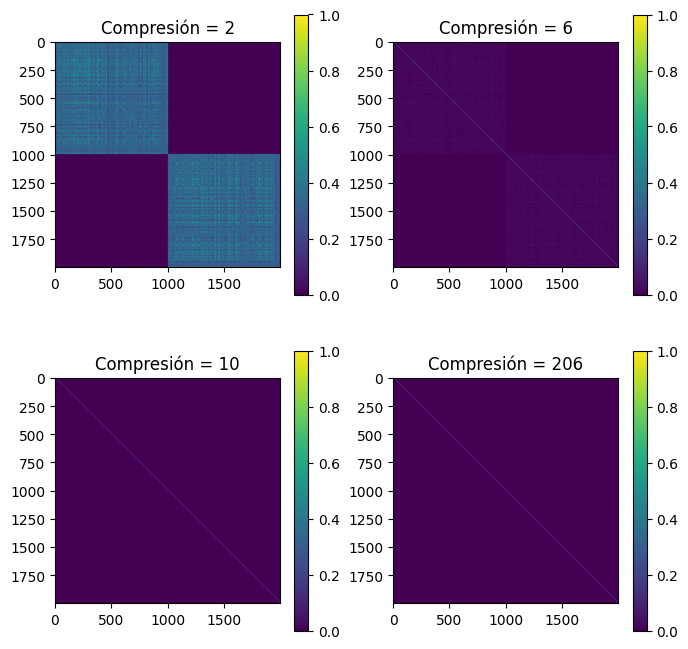

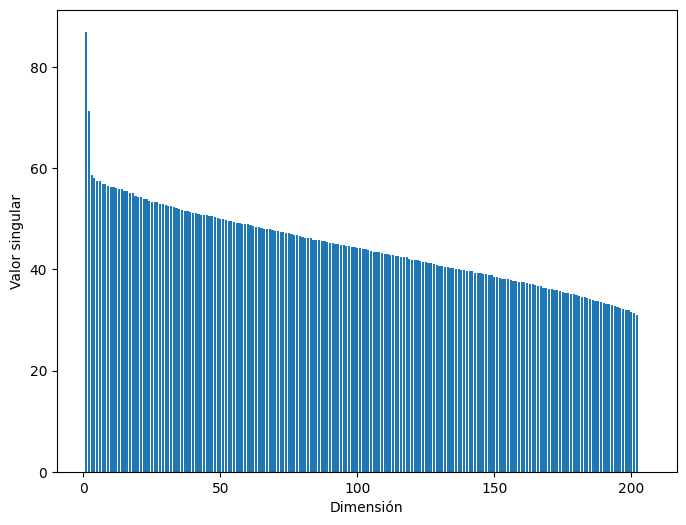

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
compression_values = [2, 6, 10]
j = 0
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('dataset01.csv')

# Remove the first row (column names)
#df = df.iloc[1:]

# Remove the first column (row numbers)
df = df.iloc[:, 1:]

# Convert the remaining columns to float
df = df.astype(float)

# Convert the DataFrame to a numpy array
X = df.values
compression_values += [X.shape[1]]
print(X.shape[1])
Y = np.loadtxt('y1.txt')



X_mean = np.mean(X, axis=0)
X_centered = X - X_mean

U,S,VT = np.linalg.svd(X_centered, full_matrices=False)
print(U.shape, S.shape, VT.shape)

xyz = np.zeros((X.shape[0],3))
for i in range(X.shape[0]):
    xyz[i,0] = VT[0,:]@X_centered[i,:]
    xyz[i,1] = VT[1,:]@X_centered[i,:]
    xyz[i,2] = VT[2,:]@X_centered[i,:]



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the x, y, and z coordinates
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2])

# Set labels for the x, y, and z axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D plot of the data')

# Show the plot
plt.show()


def similarity_matrix(matrix, sigma):
    distances = squareform(pdist(matrix, 'euclidean'))
    k = np.exp(-distances**2/(2*sigma**2))
    return k

def PCA(U, S, d):
    Sd = np.diag(S[:d])
    Ud = U[:, :d]
    Z = np.dot(Ud, Sd)
    return Sd, Ud, Z

plt.figure(figsize=(8, 8))
counter = 1
for compression in compression_values:
    VT_hat = VT[:compression, :]
    # Perform PCA
    S_hat, U_hat, XV_hat = PCA(U, S, compression)

    


    sigma = 1.0
    
    # Calculate the similarity matrix
    similarity = similarity_matrix(XV_hat, sigma)
    
    # Display the similarity matrix
    plt.subplot(2,2,counter)
    plt.imshow(similarity, cmap='viridis')
    plt.colorbar()
    plt.title('Compresión = ' + str(compression))
    # plt.show()
    counter+=1
plt.show()

        


doms = np.linspace(1,206,206)
#Singular values plot:
plt.figure(figsize=(8,6))
plt.bar(doms,S[:compression])
# plt.title('Singular values plot of the full matrix')
plt.ylabel('Valor singular')
plt.xlabel('Dimensión')
plt.show()






## Paso 2: Identificación de dimensiones más representativas

In [62]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Read the CSV file into a pandas DataFrame
# df = pd.read_csv('dataset01.csv')

# # Remove the first row (column names)
# # df = df.iloc[1:]

# # Remove the first column (row numbers)
# df = df.iloc[:, 1:]

# # Convert the remaining columns to float
# df = df.astype(float)

# # Convert the DataFrame to a numpy array
# X = df.values
# X_centered =
# Apply SVD
U, S, VT = np.linalg.svd(X_centered, full_matrices=False)

# Define the dimensions to reduce to
dimensions = [2, 6, 10]

# Function to get the most representative dimensions
def get_representative_dimensions(VT, d):
    VT_d = VT[:d, :]
    importance = np.sum(VT_d**2, axis=0)
    sorted_indices = np.argsort(importance)[::-1]

    return sorted_indices



important_dimensions = {d: get_representative_dimensions(VT, d) for d in dimensions}
for d, dims in important_dimensions.items():
    print('Most important dimensions for d =', d, ':', dims[:d])




Most important dimensions for d = 2 : [205 203]
Most important dimensions for d = 6 : [205 203 201 202 204 200]
Most important dimensions for d = 10 : [205 203 201 202 204 200  91  28 140  69]


## Paso 3: Paso 3: Modelado lineal y predicción

Index of minimum:  202 , Error:  0.220880686826309 , Norma:  1185.8675858223346


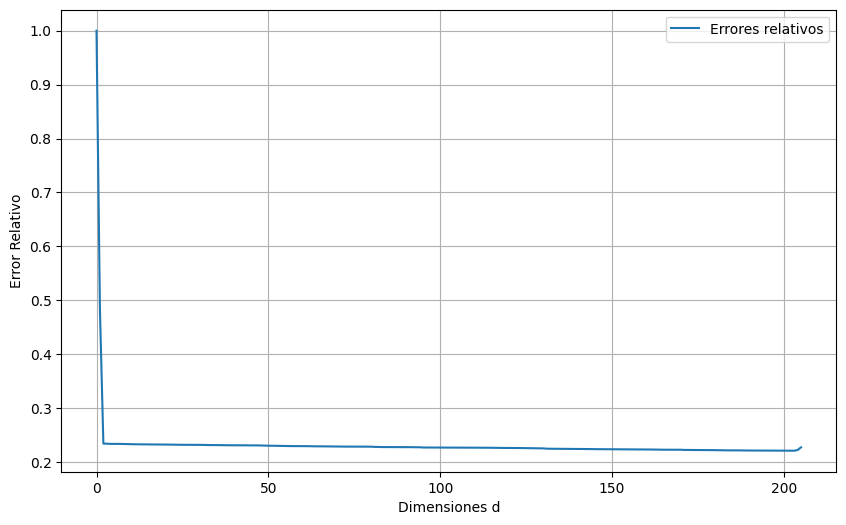

Norma of XB - Y for d = 2 : 0.2340644717705988
Norma of XB - Y for d = 6 : 0.23354436857443148
Norma of XB - Y for d = 10 : 0.23294416485741035
Norma of XB - Y for d = 206 : 0.23509663542716053


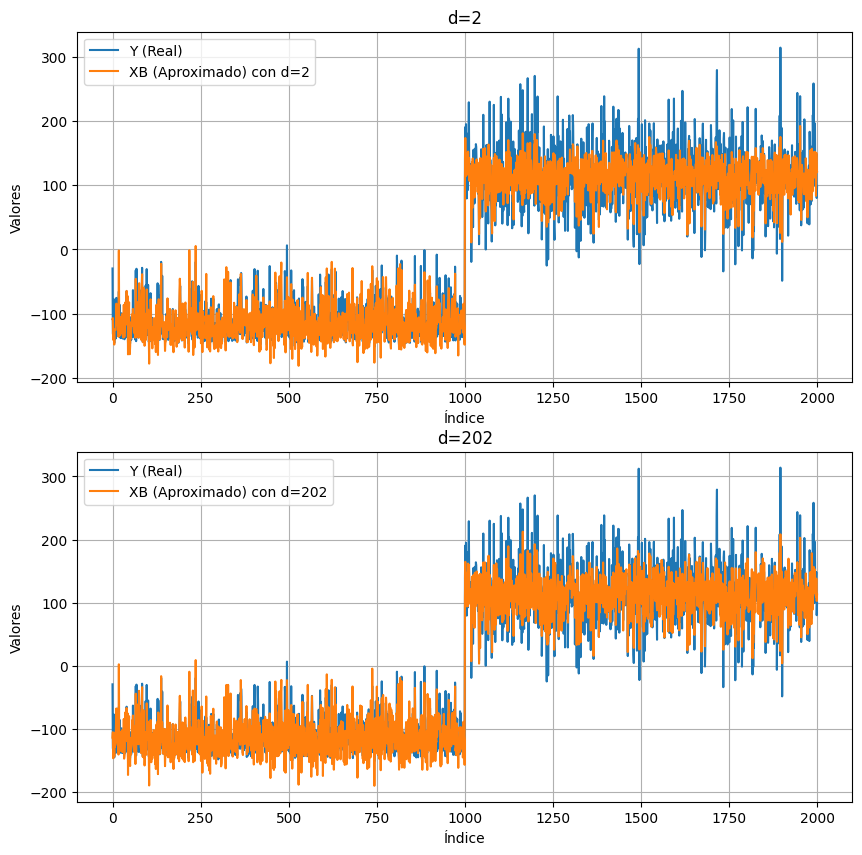

In [60]:
#I want to find B such as ||XB - Y|| is minimum so i want to find an aproximation of XB = Y. B.shape = (206,)
dimensiones = [2, 6, 10, 206]
Y_centered = Y - np.mean(Y)

# U, S, VT = np.linalg.svd(X_centered, full_matrices=False)

def pseudo_inverse(A, d):
    U, S, VT = np.linalg.svd(A, full_matrices=False)
    S_d = np.diag(1/S[:d])
    # print(S_d.shape)
    A_d = np.dot(VT.T[:,:d], S_d).dot(U.T[:d,:])
    # print(A_d.shape)
    return A_d
def absolute_error(A,B):
    abserr = 0 
    
    for i in range(A.shape[0]):
        abserr += abs(A[i]-B[i])

    return abserr
        

def find_B(X, Y, d):
    A_d = pseudo_inverse(X, d)
    B = np.dot(A_d, Y)
    return B


doms = [i for i in range(0, 206)]
relative_errors = []

# Calcular errores relativos
for d in doms:
    
    B = find_B(X_centered, Y_centered, d)
    z = np.dot(X_centered, B) - Y_centered
    relative_error = np.linalg.norm(z) / np.linalg.norm(Y_centered)
    relative_errors.append(relative_error)
    # print (d, relative_error)
print("Index of minimum: ",relative_errors.index(min(relative_errors)), ", Error: ", min(relative_errors), ", Norma: ",min(relative_errors)*np.linalg.norm(Y_centered))
# Graficar errores relativos
plt.figure(figsize=(10, 6))
plt.plot(doms, relative_errors, label="Errores relativos")
# plt.title('Error Relativo de la Aproximación XB respecto a Y')
plt.xlabel('Dimensiones d')
plt.ylabel('Error Relativo')
plt.legend()
plt.grid(True)
plt.show()

for d in dimensiones:
    B = find_B(X_centered, Y_centered, d)
    z = np.dot(X_centered, B) - Y_centered
    print('Norma of XB - Y for d =', d, ':', np.linalg.norm(z)/np.linalg.norm(Y_centered))
    # print(B[:d])


dimensiones += [202]

B2 = find_B(X_centered, Y_centered, 2)
XB2 = np.dot(X_centered, B2)
plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.plot(Y_centered, label='Y (Real)')
plt.plot(XB2, label=f'XB (Aproximado) con d={2}')
plt.title(f'd={2}')
plt.xlabel('Índice')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)

B202 = find_B(X_centered, Y_centered, 202)
XB202 = np.dot(X_centered, B202)
plt.subplot(2,1,2)

plt.plot(Y_centered, label='Y (Real)')
plt.plot(XB202, label=f'XB (Aproximado) con d={202}')
plt.title(f'd={202}')
plt.xlabel('Índice')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.show()

# for d in dimensiones:
#     B = find_B(X_centered, Y_centered, d)
#     XB = np.dot(X_centered, B)
#     plt.figure(figsize=(10, 6))
#     plt.plot(Y_centered, label='Y (Real)')
#     plt.plot(XB, label=f'XB (Aproximado) con d={d}')
#     plt.title(f'Comparación de Y y XB para d={d}')
#     plt.xlabel('Índice')
#     plt.ylabel('Valores')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

    
    

